# Training datasets performance

In [1]:
import pandas as pd

# Data import

FE = 0 # Feature Engineering (0 = No, 1 = Yes)
Out = 0 # Outliers Processing (0 = No, 1 = Yes)
FR = 0 # Feature Reduction (0 = No, 1 = Yes)

def dataset(FE, Out, FR):
    if FR == 0:
        if FE == 0:
            if Out == 0:
                X_train = pd.read_csv('data/X_train.csv') # Training data
            else:
                X_train = pd.read_csv('data/X_train_out.csv')
            X_test = pd.read_csv('data/X_test.csv') # Test data
        else:
            if Out == 0:
                X_train = pd.read_csv('data/X_train_FE.csv')
            else:
                X_train = pd.read_csv('data/X_train_FE_out.csv')
            X_test = pd.read_csv('data/X_test_FE.csv') # Test data
    else:
        X_train = pd.read_csv('data/X_train_FR.csv')
        X_test = pd.read_csv('data/X_test_FR.csv') # Test data
    
    return X_train, X_test


In [7]:
best ={'colsample_bytree': 0.723028675585211, 
       'learning_rate': 0.04124336649185381, 
       'max_depth': 11, 
       'min_child_samples': 64, 
       'n_estimators': 225, 
       'num_leaves': 57, 
       'reg_alpha': 0.6633304341560168, 
       'reg_lambda': 0.1462724496785454, 
       'subsample': 0.8214969245824829}

In [100]:
X_train, X_test = dataset(FE = 1, Out = 0, FR = 0)

y_train = X_train['Age']
X_train = X_train.drop(['Age'], axis=1)

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

"""X_train_SS= scaler.fit_transform(X_train)"""

'X_train_SS= scaler.fit_transform(X_train)'

In [102]:
Train_sets = {'Normal dataset': [0, 0, 0], 'Normal dataset without outliers': [0, 1, 0], 
              'Dataset With FE': [1, 0, 0], 'Dataset With FE without outliers': [1, 1, 0],
              'Dataset With FE and FR': [1, 1, 1]}

In [106]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

Scores = {}

"""best ={'colsample_bytree': 0.7857887738902785, 
       'learning_rate': 0.03258780738912802, 
       'max_depth': 8, 
       'min_child_samples': 55, 
       'n_estimators': 240, 
       'num_leaves': 79, 
       'reg_alpha': 0.5301178811425332, 
       'reg_lambda': 0.028710808153810163, 
       'subsample': 0.8851558334026159}"""

for name, model in Train_sets.items():
    X_train, X_test  = dataset(model[0], model[1], model[2])
    y_train = X_train['Age']
    X_train = X_train.drop(['Age'], axis=1)
    model_LGBM = lgb.LGBMRegressor(**best)                   
    mae = cross_val_score(model_LGBM, X_train, y_train, cv=10, scoring=make_scorer(mean_absolute_error)).mean()
    print("Name:", name, "MAE:", mae)
    print('')   

Name: Normal dataset MAE: 1.397573681829066

Name: Normal dataset without outliers MAE: 1.3000730046040794

Name: Dataset With FE MAE: 1.4010845935154976

Name: Dataset With FE without outliers MAE: 1.3011405112982062

Name: Dataset With FE and FR MAE: 1.423610375240086



# LightGBM model training: First shoot

## Step 1: Split Train a test datasets by outliers presence

In [12]:
# Data import 
X_train, X_test  = dataset(1, 0, 0)

In [13]:
SD = 3 # Standard Deviation

X_test_normal = X_test.copy()
X_test_out = pd.DataFrame()

for col in X_test.columns[1:]:
    # Define the condition for a value to be considered as an outlier
    condition = (X_test_normal[col] < X_test_normal[col].mean() - SD * X_test_normal[col].std()) | (X_test_normal[col] > X_test_normal[col].mean() + SD * X_test_normal[col].std())
    
    # Add outliers to X_test_out
    X_test_out = pd.concat([X_test_out, X_test_normal[condition]])
    
    # Remove outliers from X_test_normal
    X_test_normal = X_test_normal[~condition]

# The same for X_train
X_train_normal = X_train.copy()
X_train_out = pd.DataFrame()

for col in X_train.columns[1:]:

    condition = (X_train_normal[col] < X_train_normal[col].mean() - SD * X_train_normal[col].std()) | (X_train_normal[col] > X_train_normal[col].mean() + SD * X_train_normal[col].std())
    
    X_train_out = pd.concat([X_train_out, X_train_normal[condition]])
    
    X_train_normal = X_train_normal[~condition]

In [14]:
# Print shapes of datasets
print('X_test_normal shape: ', X_test_normal.shape)
print('X_test_out shape: ', X_test_out.shape)
print('X shape: ', X_test.shape)

print('X_train_normal shape: ', X_train_normal.shape)
print('X_train_out shape: ', X_train_out.shape)
print('X_train shape: ', X_train.shape)

X_test_normal shape:  (46672, 14)
X_test_out shape:  (2696, 14)
X shape:  (49368, 14)
X_train_normal shape:  (69817, 11)
X_train_out shape:  (4234, 11)
X_train shape:  (74051, 11)


## Step 2: Modelling 

### Modelling no outliers observations of test

In [8]:
import lightgbm as lgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error
import lightgbm as lgb

In [15]:
y_train_norm = X_train_normal['Age']
X_train_norm = X_train_normal.drop(['Age'], axis=1)


In [17]:
space ={
    'max_depth': hp.quniform('max_depth', 2, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.015, 0.07),
    'num_leaves': hp.quniform('num_leaves', 5, 100, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1.0),
    'subsample': hp.uniform('subsample', 0.01, 1.0),
    'n_estimators': hp.quniform('n_estimators', 20, 300, 5),
    'min_child_samples': hp.quniform('min_child_samples', 2, 100, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0)
}

# Función objetivo para hyperopt
def objective(space):
    model_LGBM = lgb.LGBMRegressor(max_depth = int(space['max_depth']),
                             learning_rate = space['learning_rate'],
                             num_leaves = int(space['num_leaves']),
                             n_estimators = int(space['n_estimators']),
                             colsample_bytree = space['colsample_bytree'],
                             subsample = space['subsample'],
                             min_child_samples = int(space['min_child_samples']),
                             reg_alpha = space['reg_alpha'],
                             reg_lambda = space['reg_lambda'])
    
                             
    mae = cross_val_score(model_LGBM, X_train_norm, y_train_norm, cv=5, scoring=make_scorer(mean_absolute_error)).mean()

    return {'loss': mae, 'status': STATUS_OK}


# Run the algorithm
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=1200,
            trials=trials)

print("Best: ", best)


  0%|          | 0/1200 [00:00<?, ?trial/s, best loss=?]

  1%|▏         | 16/1200 [00:38<47:39,  2.42s/trial, best loss: 1.3291359968290102]


KeyboardInterrupt: 

In [11]:
best ={'colsample_bytree': 0.723028675585211, 
       'learning_rate': 0.04124336649185381, 
       'max_depth': 11, 
       'min_child_samples': 64, 
       'n_estimators': 225, 
       'num_leaves': 57, 
       'reg_alpha': 0.6633304341560168, 
       'reg_lambda': 0.1462724496785454, 
       'subsample': 0.8214969245824829}

In [13]:
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['n_estimators'] = int(best['n_estimators'])
best['min_child_samples'] = int(best['min_child_samples'])

# Creamos el modelo con los mejores hiperparámetros obtenidos
model_LGBM = lgb.LGBMRegressor(max_depth = int(best['max_depth']),
                          learning_rate = best['learning_rate'],
                          num_leaves = int(best['num_leaves']),
                          n_estimators = int(best['n_estimators']),
                          colsample_bytree = best['colsample_bytree'],
                          subsample = best['subsample'],
                          min_child_samples = int(best['min_child_samples']),
                          reg_alpha = best['reg_alpha'],
                          reg_lambda = best['reg_lambda'])

In [27]:
model_LGBM = lgb.LGBMRegressor(**best)                   
mae = cross_val_score(model_XGB, X_train_norm, y_train_norm, cv=10, scoring=make_scorer(mean_absolute_error)).mean()
print("MAE:", mae)

MAE: 1.4702992300523805


In [22]:
X_train_norm.head()

,Length,Diameter,Height,Sex_F,Sex_I,Sex_M,LogWeight,LogShuckedWeight,LogVisceraWeight,LogShellWeight
0,1.5250,1.1750,0.3750,0,1,0,1.461996,1.104792,0.822688,0.921631
1,1.1000,0.8250,0.2750,0,1,0,1.017803,0.655306,0.366359,0.531727
2,1.3875,1.1125,0.3750,0,0,1,1.394057,1.054605,0.744801,0.823613
3,1.7000,1.4125,0.5000,1,0,0,1.704670,1.308670,1.041070,1.176001
4,1.2500,1.0125,0.3375,0,1,0,1.367153,1.078372,0.653943,0.774765


In [16]:
import numpy as np
import pandas as pd

y_pred_normal = model_LGBM.fit(X_train_norm, y_train_norm).predict(X_test_normal)
y_pred_normal = pd.DataFrame(y_pred_normal, columns=['Age'])

ValueError: Number of features of the model must match the input. Model n_features_ is 10 and input n_features is 14

In [138]:
# Concatenate y_pred_normal and X_test_normal
y_pred_new = pd.DataFrame(data=y_pred_normal.values, index=X_test_normal.index, columns=y_pred_normal.columns)
X_test_n = pd.concat([X_test_normal,y_pred_new], axis=1)

#### Solution analysis

In [139]:
y_pred_normal_train = np.round(model_XGB.fit(X_train_norm, y_train_norm).predict(X_train_norm),0)
Error = (y_train_norm - y_pred_normal_train).to_frame(name='Error')
y_pred_normal_train = pd.DataFrame(y_pred_normal_train, columns=['Age_pred'])

In [140]:
y_pred_normal_train = pd.DataFrame(data=y_pred_normal_train.values, index=X_train_normal.index, columns=y_pred_normal_train.columns)

In [141]:
X_train_No_outliers = pd.concat([X_train_normal, y_pred_normal_train, Error], axis=1)

In [142]:
X_train_No_outliers.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M,Age_pred,Error
0,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,0,1,0,10.0,-1.0
1,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,0,1,0,8.0,0.0
2,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,0,0,1,9.0,0.0
3,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,1,0,0,12.0,-1.0
4,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,0,1,0,8.0,0.0


### Modelling outliers observations of test

In [143]:
y_train_norm = X_train_out['Age']
X_train_norm = X_train_out.drop(['Age'], axis=1)
y_train_norm = y_train_norm.squeeze()


In [134]:
import lightgbm as lgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error

space ={
    'max_depth': hp.quniform('max_depth', 2, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.015, 0.07),
    'num_leaves': hp.quniform('num_leaves', 5, 100, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1.0),
    'subsample': hp.uniform('subsample', 0.01, 1.0),
    'n_estimators': hp.quniform('n_estimators', 20, 300, 5),
    'min_child_samples': hp.quniform('min_child_samples', 2, 100, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0)
}

# Función objetivo para hyperopt
def objective(space):
    model_LGBM = lgb.LGBMRegressor(max_depth = int(space['max_depth']),
                             learning_rate = space['learning_rate'],
                             num_leaves = int(space['num_leaves']),
                             n_estimators = int(space['n_estimators']),
                             colsample_bytree = space['colsample_bytree'],
                             subsample = space['subsample'],
                             min_child_samples = int(space['min_child_samples']),
                             reg_alpha = space['reg_alpha'],
                             reg_lambda = space['reg_lambda'])
    
                             
    mae = cross_val_score(model_LGBM, X_train_norm, y_train_norm, cv=10, scoring=make_scorer(mean_absolute_error)).mean()

    return {'loss': mae, 'status': STATUS_OK}


# Run the algorithm
trials = Trials()
best_norm = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=2000,
            trials=trials)

print("Best: ", best_norm)

  0%|          | 0/2000 [00:00<?, ?trial/s, best loss=?]

  1%|          | 21/2000 [01:12<1:54:17,  3.47s/trial, best loss: 1.4202892263920792]


KeyboardInterrupt: 

In [82]:
import lightgbm as lgb

# Creamos el modelo con los mejores hiperparámetros obtenidos
model_LGBM = lgb.LGBMRegressor(max_depth = int(best_norm['max_depth']),
                          learning_rate = best_norm['learning_rate'],
                          num_leaves = int(best_norm['num_leaves']),
                          n_estimators = int(best_norm['n_estimators']),
                          colsample_bytree = best_norm['colsample_bytree'],
                          subsample = best_norm['subsample'],
                          min_child_samples = int(best_norm['min_child_samples']),
                          reg_alpha = best_norm['reg_alpha'],
                          reg_lambda = best_norm['reg_lambda'])

mae = cross_val_score(model_LGBM, X_train_norm, y_train_norm, cv=10, scoring=make_scorer(mean_absolute_error)).mean()
print("MAE:", mae)

MAE: 2.0845837218824697


In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb


y_train_at = X_train['Age']
X_train_at = X_train.drop(['Age'], axis=1)
#model_LGBM_aty= lgb.LGBMRegressor(**best)                   
mae = cross_val_score(model_XGB , X_train_at, y_train_at, cv=10, scoring=make_scorer(mean_absolute_error)).mean()
print("MAE:", mae)

MAE: 1.5127613254163124


In [145]:
y_pred_aty = model_XGB.fit(X_train_at, y_train_at).predict(X_test_out)

In [146]:
y_A = pd.DataFrame(y_pred_aty, columns=['Age'])

In [147]:
y_A_new = pd.DataFrame(data=y_A.values, index=X_test_out.index, columns=y_A.columns)
X_test_aty = pd.concat([X_test_out, y_A_new], axis=1).sort_index()

#### Solution analysis

In [148]:
X_train_out.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M
236,0.4250,0.3000,0.1500,0.680388,0.255146,0.141747,0.255146,5,0,1,0
356,0.4125,0.2875,0.0625,0.510291,0.184272,0.141747,0.141747,4,0,1,0
461,0.4000,0.1375,0.1125,0.595340,0.212621,0.127573,0.127573,3,0,1,0
746,0.4125,0.3000,0.1125,0.595340,0.212621,0.127573,0.212621,4,0,1,0
936,0.4000,0.2750,0.0750,0.666213,0.212621,0.226796,0.141747,4,0,1,0


In [149]:
X_train_out2 = X_train_out.drop(['Age'], axis=1)

y_pred_out_train = np.round(model_XGB.fit(X_train_out2, X_train_out['Age']).predict(X_train_out2),0)
Error_out = (X_train_out['Age'] - y_pred_out_train).to_frame(name='Error')

In [150]:
X_train_out.shape

(2012, 11)

In [151]:
y_pred_out_train.shape

(2012,)

In [152]:
Error_out.shape

(2012, 1)

In [153]:
y_pred_out_train = pd.DataFrame(y_pred_out_train, columns=['Age_pred'])

In [154]:
X_train_out = X_train_out.reset_index(drop=True)
y_pred_out_train = y_pred_out_train.reset_index(drop=True)
Error_out = Error_out.reset_index(drop=True)

X_train_outliers = pd.concat([X_train_out, y_pred_out_train, Error_out], axis=1)

In [155]:
X_train_No_outliers = X_train_No_outliers.reset_index(drop=True)
X_train_outliers = X_train_outliers.reset_index(drop=True)

X_train_analysis = pd.concat([X_train_No_outliers, X_train_outliers], axis=0)

In [156]:
X_train_analysis.to_csv('data/X_train_analysis.csv', index=False)
X_train_No_outliers.to_csv('data/X_train_analysisNO.csv', index=False)
X_train_outliers.to_csv('data/X_train_analysisO.csv', index=False)

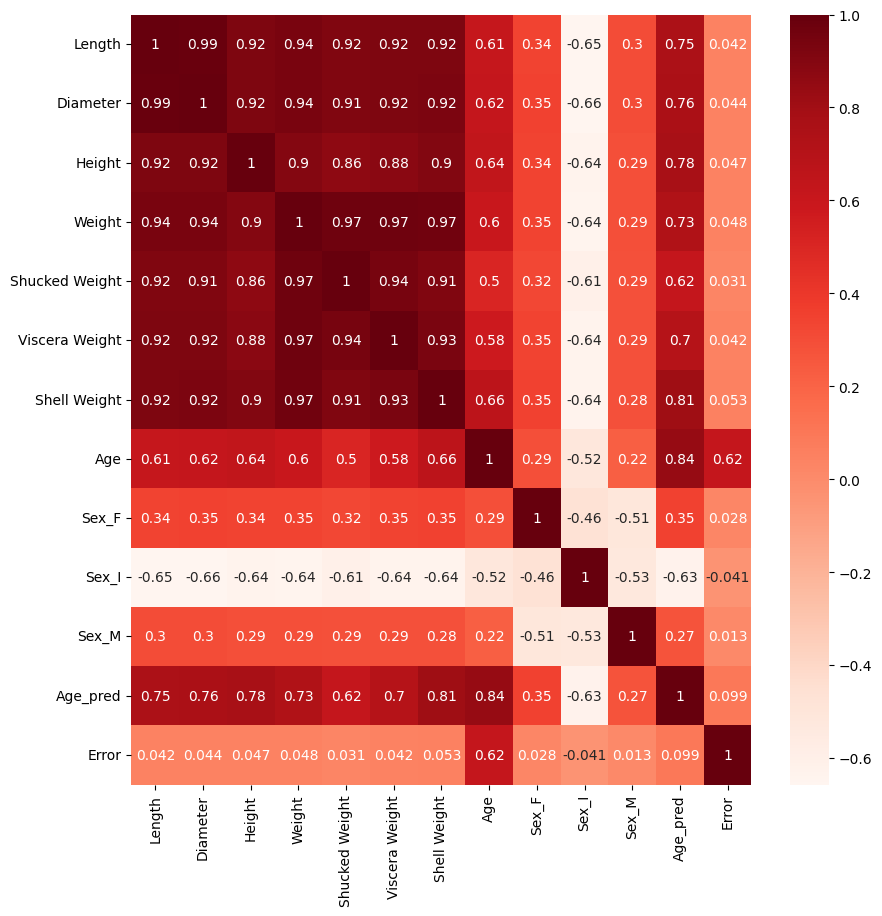

In [157]:
# Correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

corr = X_train_analysis.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

## Concatenate X_test_normal and X_test_out 

In [158]:
# Conactenate X_test_normal and X_test_out keeping previous order
X_test_final = pd.concat([X_test_n, X_test_aty]).sort_index()

# Model Comparison

In [49]:
# Comparison of the different models with cross validation
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt



X_tr, X_te = dataset(0,0,0)
y_tra = X_tr['Age']
X_tra = X_tr.drop(['Age'], axis=1)
X_tra= scaler.fit_transform(X_tra)

models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor()),
    ("Random Forest", RandomForestRegressor()),
    ("Knn", KNeighborsRegressor()),
    ("XGB", XGBRegressor(eval_metric='mae')),
    ("LGBM", LGBMRegressor())
]

cv = KFold(n_splits=5, shuffle=True, random_state=1)  # KFold cross-validator

model_scores = {}

for name, model in models:
    scores = -1 * cross_val_score(model, X_tra, y_tra, cv = cv, scoring='neg_mean_absolute_error')
    model_scores[name] = scores

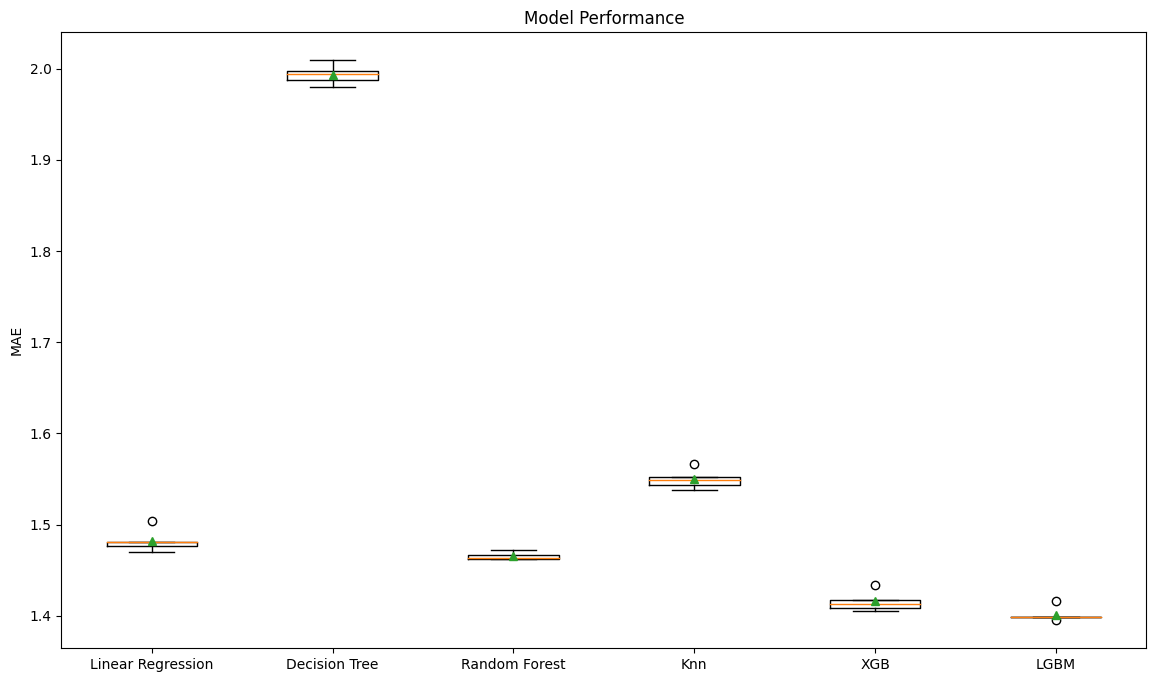

In [50]:
plt.boxplot(model_scores.values(), labels=model_scores.keys(), showmeans=True)
plt.rcParams['figure.figsize'] = [14, 8] #Size of the plot (width, height)
plt.ylabel("MAE")
plt.title("Model Performance")
plt.show()

# Models training

## Random Forest

In [229]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

# Dividir los datos de entrenamiento en un conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'max_depth': hp.quniform('max_depth', 5, 30, 1),
    'max_features': hp.choice('max_features', [1.0, 'sqrt', 'log2']), # Reemplazado 'auto' por 1.0
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)
}

# Función objetivo para Hyperopt
def objective(params):
    # Convierte los parámetros numéricos a enteros
    params = {'n_estimators': int(params['n_estimators']),
              'max_depth': int(params['max_depth']),
              'max_features': params['max_features'],
              'min_samples_split': int(params['min_samples_split']),
              'min_samples_leaf': int(params['min_samples_leaf'])}

    # Entrenar y predecir con el modelo RandomForestRegressor
    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    # Calcular la métrica MAE
    mae = mean_absolute_error(y_val, y_pred)

    return {'loss': mae, 'status': STATUS_OK}

# Ejecutar la optimización de hiperparámetros
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)

print("Mejores hiperparámetros encontrados: ", best)


  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

job exception: could not convert string to float: 'M'



  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]


ValueError: could not convert string to float: 'M'

In [43]:
max_features_options = [1.0, 'sqrt', 'log2']  # Las opciones originales para 'max_features'

model_RF = RandomForestRegressor(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    max_features=max_features_options[best['max_features']],  # Convertir índice a valor
    min_samples_split=int(best['min_samples_split']),
    min_samples_leaf=int(best['min_samples_leaf']),
    random_state=42
)

model_RF.fit(X_train_Modelling_MC, y_train)

RandomForestRegressor(max_depth=13, max_features='log2', min_samples_leaf=6,
                      min_samples_split=3, n_estimators=500, random_state=42)

## Lasso

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_Modelling_SS = scaler.fit_transform(X_train_Modelling_MC)

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np

# train test split
X_train, X_val, y_train, y_val = train_test_split(X_train_Modelling_SS, y_train, test_size=0.2, random_state=1)

train_scores = []
val_scores = []

alphas = np.linspace(0.004, 0.8, num=100)


for alpha in alphas:
    model = Lasso(alpha=alpha)
    model.fit(X_train, y_train)
    
    train_score = mean_absolute_error(y_train, model.predict(X_train))
    val_score = mean_absolute_error(y_val, model.predict(X_val))
    
    train_scores.append(train_score)
    val_scores.append(val_score)

# Calculate the difference between training and validation scores
score_diff = [train_scores[i] - val_scores[i] for i in range(len(train_scores))]

# Perform cross-validation
cv_scores = []
for alpha in alphas:
    model = Lasso(alpha=alpha)
    cv_scores.append(-np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')))


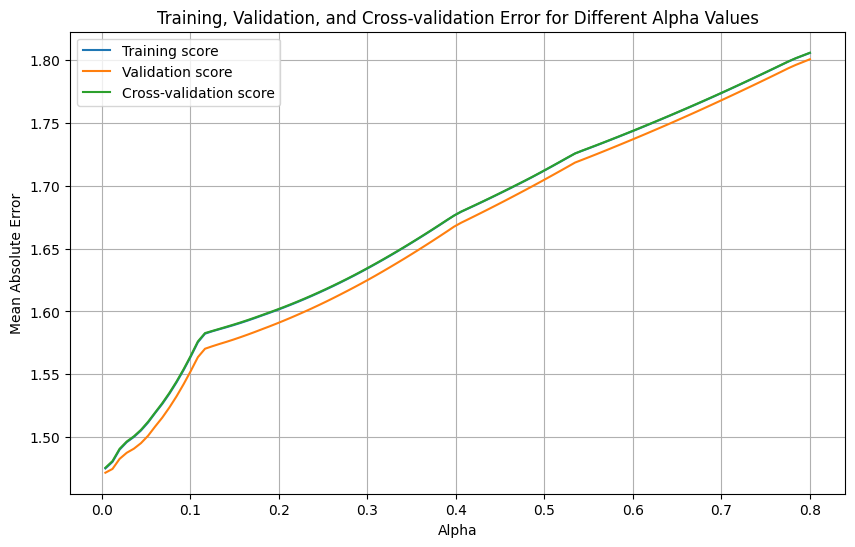

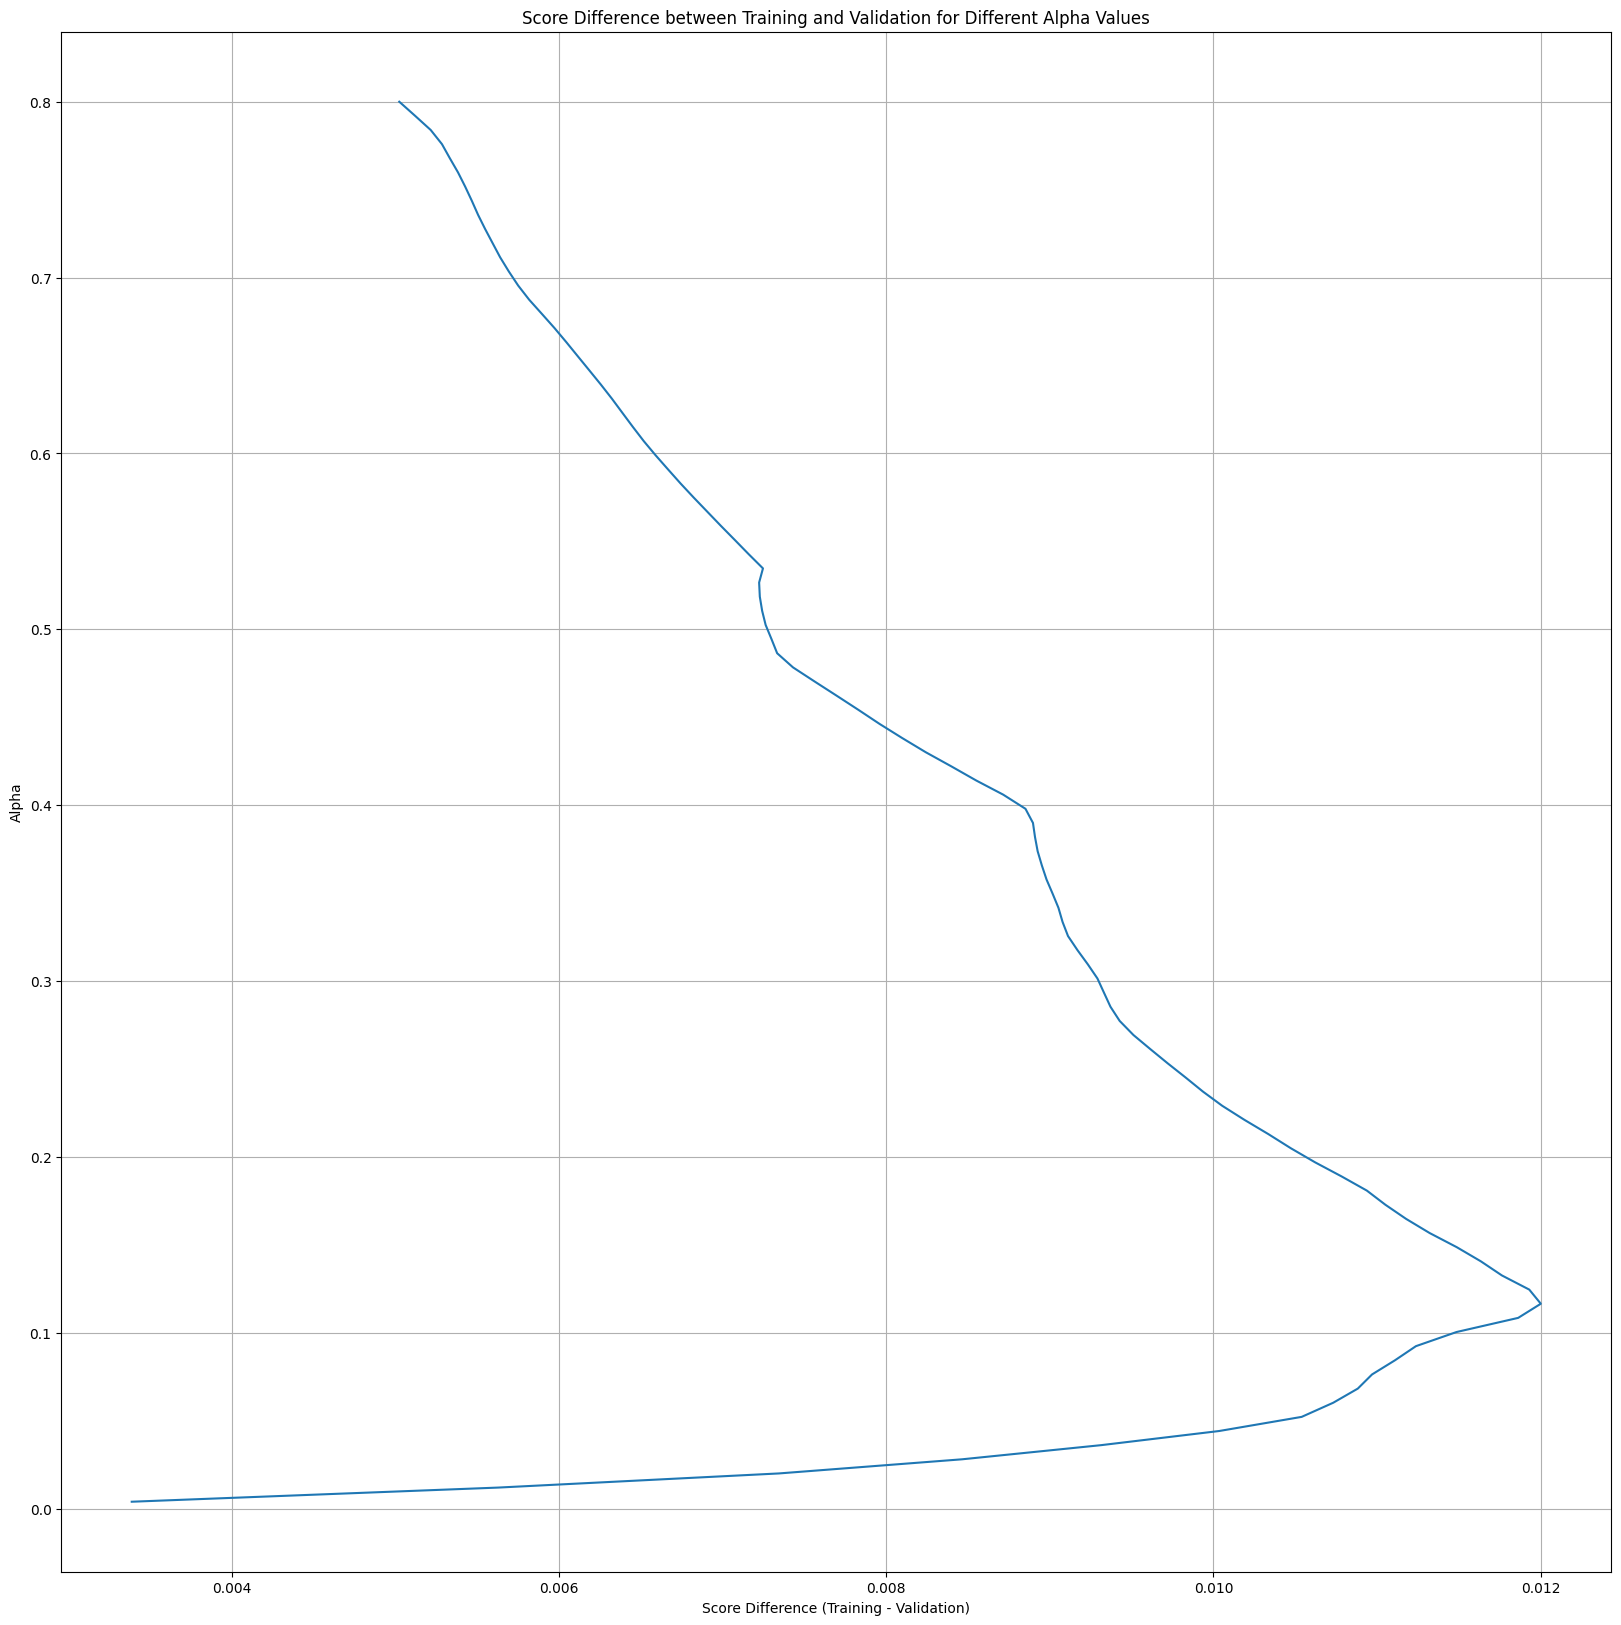

In [46]:

# Plot the scores
plt.figure(figsize=(10,6))
plt.plot(alphas, train_scores, label='Training score')
plt.plot(alphas, val_scores, label='Validation score')
plt.plot(alphas, cv_scores, label='Cross-validation score')
plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error')
plt.title('Training, Validation, and Cross-validation Error for Different Alpha Values')
plt.legend()
plt.grid()
plt.show()

# Plot the score difference
plt.plot(score_diff, alphas)
plt.ylabel('Alpha')
plt.xlabel('Score Difference (Training - Validation)')
plt.title('Score Difference between Training and Validation for Different Alpha Values')
plt.grid()
plt.show()

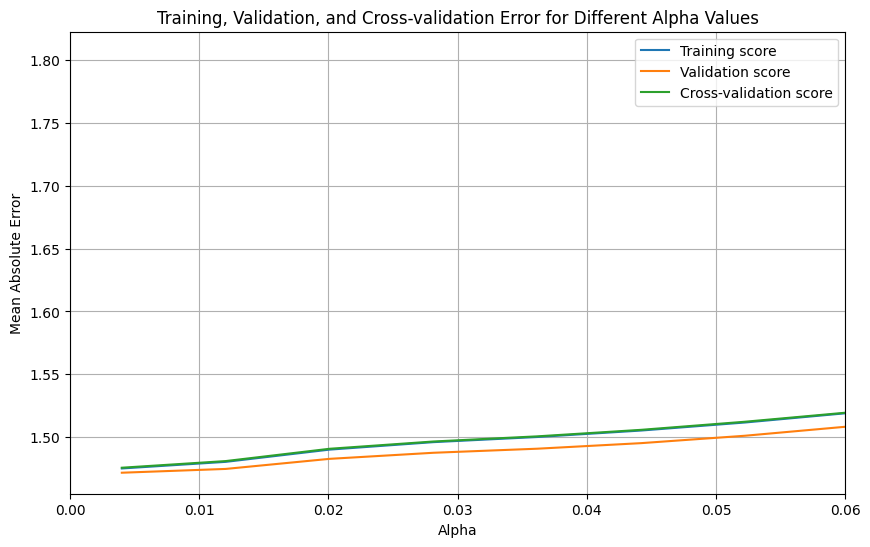

In [68]:
# Plot the scores
plt.figure(figsize=(10,6))
plt.plot(alphas, train_scores, label='Training score')
plt.plot(alphas, val_scores, label='Validation score')
plt.plot(alphas, cv_scores, label='Cross-validation score')
plt.xlim(0, 0.06)




plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error')
plt.title('Training, Validation, and Cross-validation Error for Different Alpha Values')
plt.legend()
plt.grid()
plt.show()

In [72]:
from sklearn.linear_model import Lasso

model_Lasso = Lasso(alpha=0.055)
model_Lasso.fit(X_train_Modelling_SS, y_train)


Lasso(alpha=0.055)

## KNN

In [50]:
from sklearn.model_selection import train_test_split
from hyperopt import fmin, tpe, hp, Trials, space_eval, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, make_scorer

# Hyperparameter search space
space ={
    'n_neighbors': hp.quniform('n_neighbors', 2, 25, 1),
    'weights': hp.choice('weights', ['uniform']),
    'p': hp.choice('p', [1, 2]),
}


# First, split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_Modelling_SS, y_train, test_size=0.2, random_state=42)

def objective(params):
    # Make sure to convert n_neighbors to an integer because hp.quniform returns a float
    params['n_neighbors'] = int(params['n_neighbors'])
    
    # Instantiate the model with the given parameters
    model_Knn_0 = KNeighborsRegressor(**params)

    # Train the model on the training set
    model_Knn_0.fit(X_train, y_train)
    
    # Calculate the performance on the training and validation sets
    train_score = mean_absolute_error(y_train, model_Knn_0.predict(X_train))
    val_score = mean_absolute_error(y_val, model_Knn_0.predict(X_val))
    
    # Calculate the loss as the validation score plus a penalty for overfitting
    loss = val_score + np.square(train_score - val_score)
    
    return {'loss': loss, 'status': STATUS_OK}


# Run the algorithm
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

# Get the best hyperparameters
best_params = space_eval(space, best)

print("Best: ", best_params)

100%|██████████| 50/50 [16:26<00:00, 19.73s/trial, best loss: 1.447091724342052]
Best:  {'n_neighbors': 25.0, 'p': 1, 'weights': 'uniform'}


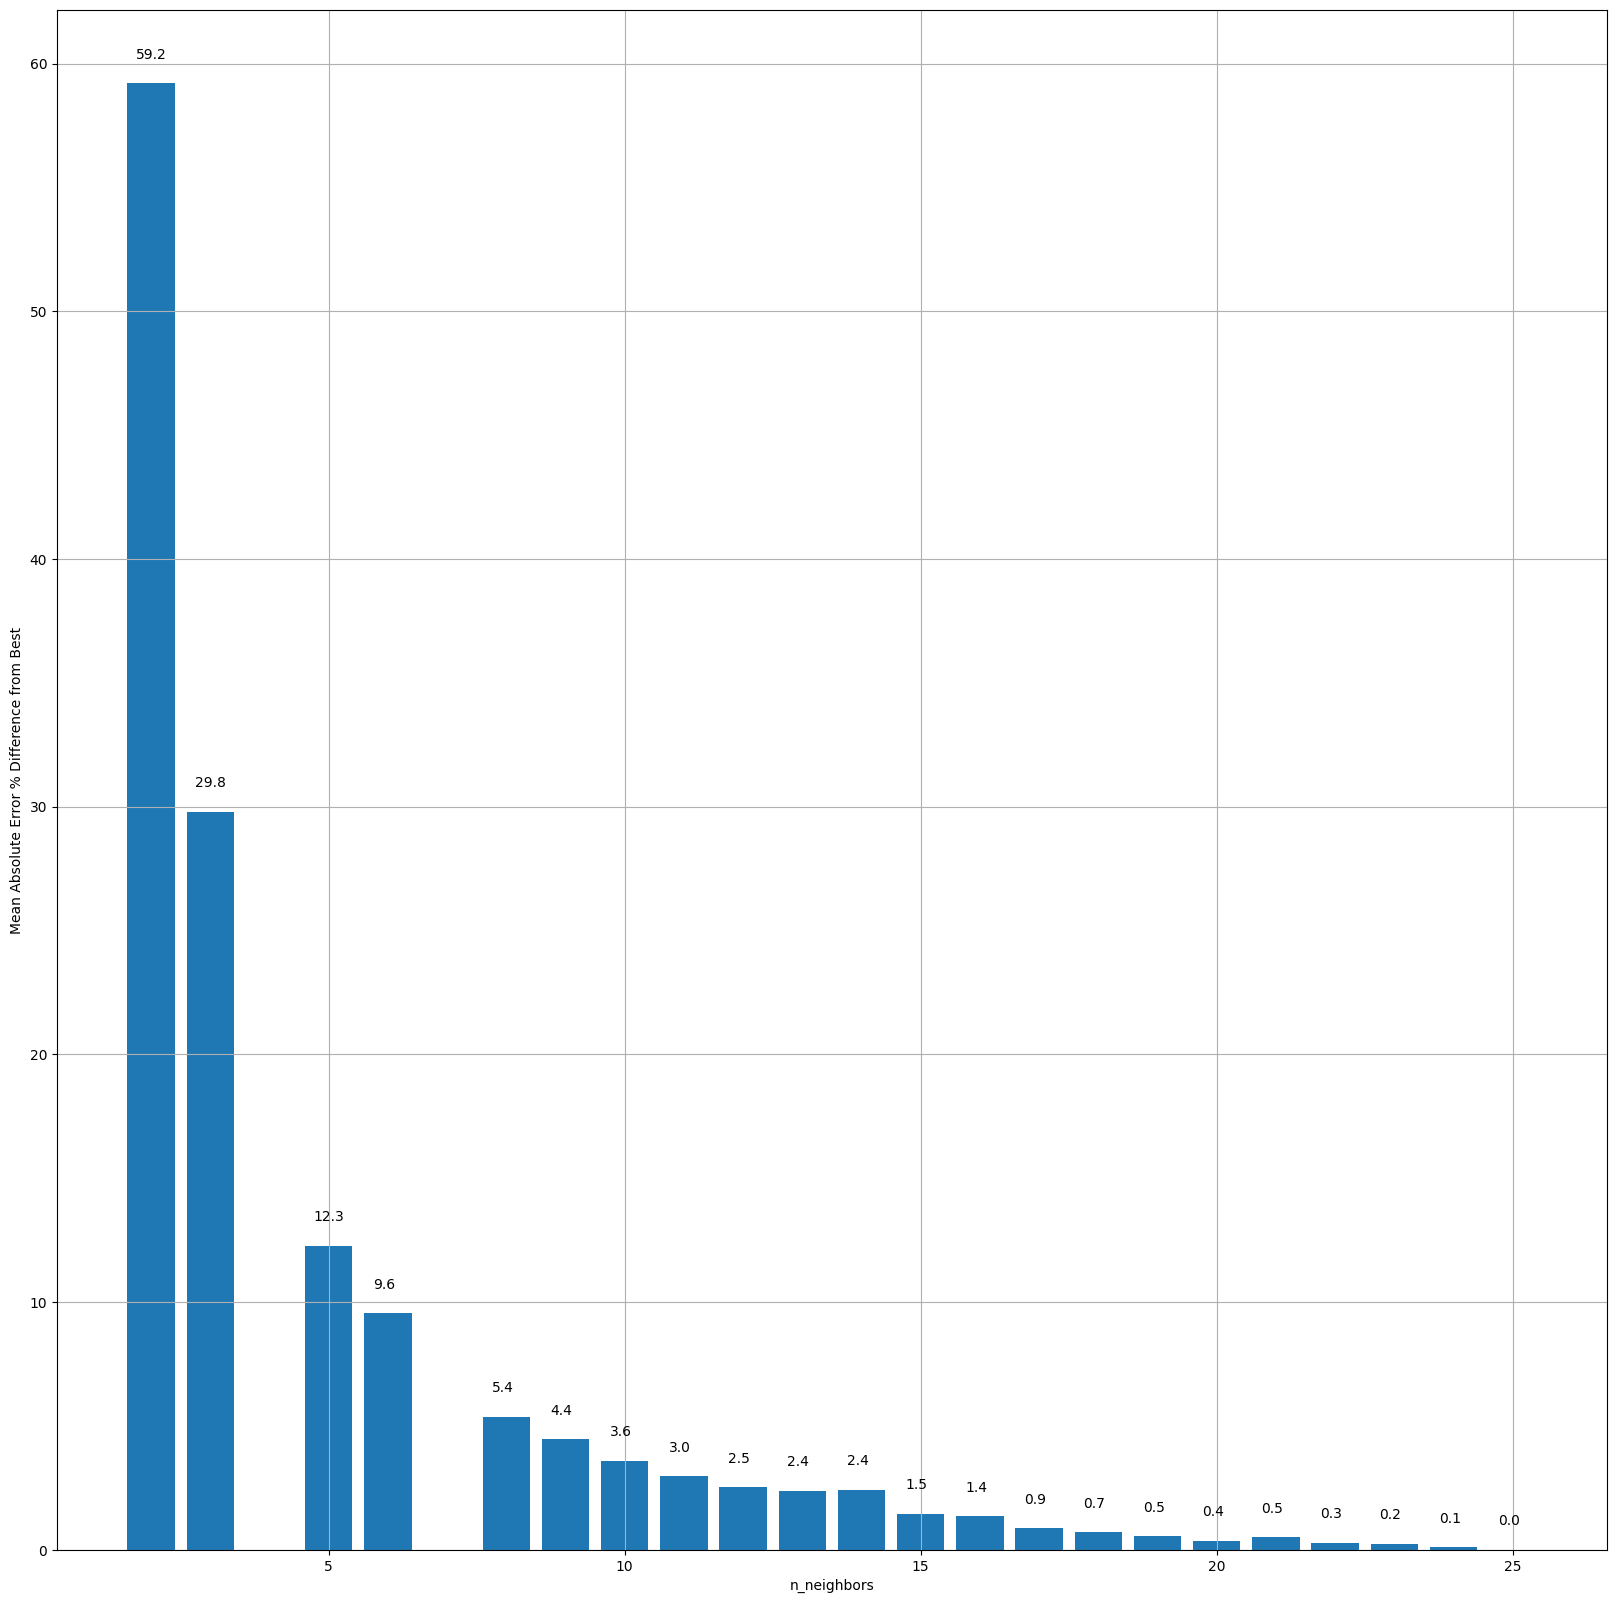

In [51]:
import matplotlib.pyplot as plt
import numpy as np

trial_list = trials.trials

# Extract the MAE scores from the trials
mae_scores = np.array([trial['result']['loss'] for trial in trial_list])

# Extract the n_neighbors values from the trials
n_neighbors_values = np.array([trial['misc']['vals']['n_neighbors'][0] for trial in trial_list])

# Get the unique n_neighbors values and their indices
unique_n_neighbors, indices = np.unique(n_neighbors_values, return_inverse=True)

# Calculate the average MAE score for each unique n_neighbors value
average_mae_scores = [mae_scores[indices == i].mean() for i in range(len(unique_n_neighbors))]

# Calculate the percentage difference of each MAE score from the best MAE score
best_score = min(average_mae_scores)
mae_scores_perc_diff = [100 * (x - best_score) / best_score for x in average_mae_scores]

# Plot
plt.bar(unique_n_neighbors, mae_scores_perc_diff)
# Show value over each bar centered above bar with 1% offset vertically
for i in range(len(unique_n_neighbors)):
    plt.text(x = unique_n_neighbors[i] - 0.25, y = mae_scores_perc_diff[i] + 1, s = round(mae_scores_perc_diff[i], 1))
plt.xlabel('n_neighbors')
plt.ylabel('Mean Absolute Error % Difference from Best')
plt.grid(True)
plt.show()


In [54]:
# Crea un modelo con los mejores hiperparámetros
model_knn= KNeighborsRegressor(n_neighbors=21,
                            weights='uniform',
                            p=1)

# Entrena el modelo
model_knn.fit(X_train_Modelling_SS, y_train)

KNeighborsRegressor(n_neighbors=21, p=1)

## LightGBM

In [126]:
X_train_Modelling_MC, X_test  = dataset(0, 0, 0)
y_train = X_train_Modelling_MC['Age']
X_train_Modelling_MC = X_train_Modelling_MC.drop(['Age'], axis=1)

In [130]:
import lightgbm as lgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error

space ={
    'max_depth': hp.quniform('max_depth', 2, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.015, 0.07),
    'num_leaves': hp.quniform('num_leaves', 5, 100, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1.0),
    'subsample': hp.uniform('subsample', 0.01, 1.0),
    'n_estimators': hp.quniform('n_estimators', 20, 300, 5),
    'min_child_samples': hp.quniform('min_child_samples', 2, 100, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0)
}


# Función objetivo para hyperopt
def objective(space):
    model_LGBM = lgb.LGBMRegressor(max_depth = int(space['max_depth']),
                             learning_rate = space['learning_rate'],
                             num_leaves = int(space['num_leaves']),
                             n_estimators = int(space['n_estimators']),
                             colsample_bytree = space['colsample_bytree'],
                             subsample = space['subsample'],
                             min_child_samples = int(space['min_child_samples']),
                             reg_alpha = space['reg_alpha'],
                             reg_lambda = space['reg_lambda'])
                             
    mae = cross_val_score(model_LGBM, X_train_Modelling_MC, y_train, cv=5, scoring=make_scorer(mean_absolute_error)).mean()

    return {'loss': mae, 'status': STATUS_OK}


# Run the algorithm
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=400,
            trials=trials)

print("Best: ", best)


  0%|          | 0/400 [00:00<?, ?trial/s, best loss=?]

 27%|██▋       | 108/400 [05:06<13:48,  2.84s/trial, best loss: 1.3985472908716432]


KeyboardInterrupt: 

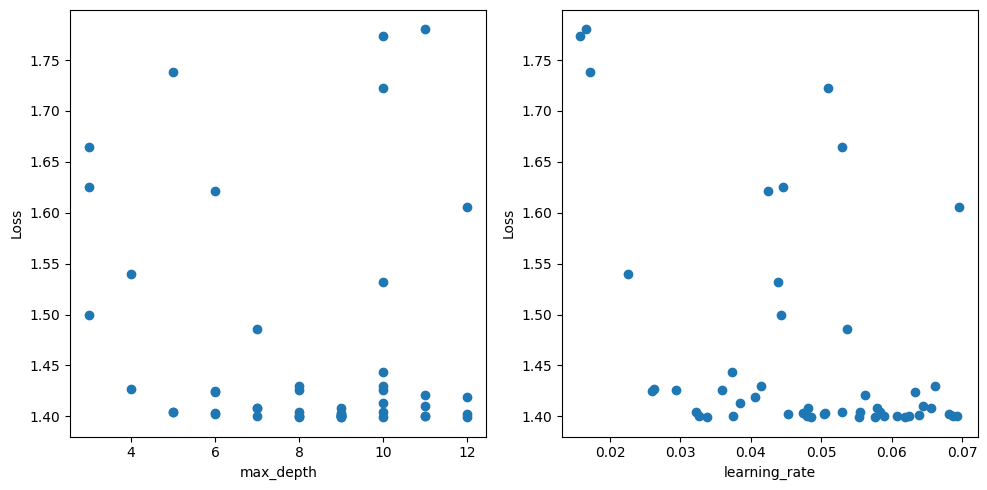

In [288]:
# Extrae los resultados
max_depth = [x['misc']['vals']['max_depth'] for x in trials.trials]
learning_rate = [x['misc']['vals']['learning_rate'] for x in trials.trials]
losses = [x['result']['loss'] for x in trials.trials]

# Grafica los resultados
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.scatter(max_depth, losses)
plt.xlabel('max_depth')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.scatter(learning_rate, losses)
plt.xlabel('learning_rate')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


In [244]:
import lightgbm as lgb

# Creamos el modelo con los mejores hiperparámetros obtenidos
model_LGBM = lgb.LGBMRegressor(max_depth = int(best['max_depth']),
                          learning_rate = best['learning_rate'],
                          num_leaves = int(best['num_leaves']),
                          n_estimators = int(best['n_estimators']),
                          colsample_bytree = best['colsample_bytree'],
                          subsample = best['subsample'],
                          min_child_samples = int(best['min_child_samples']),
                          reg_alpha = best['reg_alpha'],
                          reg_lambda = best['reg_lambda'])


# Entrenamos el modelo con nuestros datos de entrenamiento
model_LGBM.fit(X_train_Modelling_MC, y_train)


LGBMRegressor(colsample_bytree=0.8235877962900493,
              learning_rate=0.056736988698903826, max_depth=9,
              min_child_samples=78, n_estimators=295, num_leaves=25,
              reg_alpha=0.7814520599301189, reg_lambda=0.7726806405170936,
              subsample=0.7680142497535167)

## Neural Network

In [70]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam


X_train_Modelling_MC, X_test  = dataset(0, 0, 0)
y_train = X_train_Modelling_MC['Age']
X_train_Modelling_MC = X_train_Modelling_MC.drop(['Age'], axis=1)
# asumiendo que X e y son tus datos y etiquetas respectivamente
# y que ya se encuentran preparados para entrenamiento

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_val, y_train, y_val = train_test_split(X_train_Modelling_MC, y_train, test_size=0.2, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

early_stopping = EarlyStopping(monitor='val_loss', patience=20)
opt = Adam(learning_rate=0.0001)


# Crear el modelo
model_NN = Sequential()
model_NN.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))  # Capa de entrada
model_NN.add(Dense(128, activation='relu'))  # Capa oculta
model_NN.add(Dense(1, activation='linear'))  # Capa de salida

# Compilar el modelo
model_NN.compile(loss='mean_absolute_error', optimizer=opt)

# Entrenar el modelo
history = model_NN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64, callbacks=[early_stopping])

Epoch 1/100
926/926 [==============================] - 2s 2ms/step - loss: 6.2421 - val_loss: 3.2397
Epoch 2/100
926/926 [==============================] - 2s 2ms/step - loss: 2.4171 - val_loss: 1.7527
Epoch 3/100
926/926 [==============================] - 1s 1ms/step - loss: 1.5987 - val_loss: 1.5480
Epoch 4/100
926/926 [==============================] - 1s 1ms/step - loss: 1.5203 - val_loss: 1.4991
Epoch 5/100
926/926 [==============================] - 1s 1ms/step - loss: 1.4836 - val_loss: 1.4716
Epoch 6/100
926/926 [==============================] - 1s 2ms/step - loss: 1.4630 - val_loss: 1.4584
Epoch 7/100
926/926 [==============================] - 1s 2ms/step - loss: 1.4521 - val_loss: 1.4469
Epoch 8/100
926/926 [==============================] - 1s 2ms/step - loss: 1.4453 - val_loss: 1.4427
Epoch 9/100
926/926 [==============================] - 1s 1ms/step - loss: 1.4411 - val_loss: 1.4402
Epoch 10/100
926/926 [==============================] - 1s 2ms/step - loss: 1.4379 - val_lo

In [58]:
# Evaluar el modelo
train_mae = model_NN.evaluate(X_train, y_train, verbose=0)
val_mae = model_NN.evaluate(X_val, y_val, verbose=0)

print(f"Train MAE: {train_mae}")
print(f"Validation MAE: {val_mae}")

Train MAE: 1.3716166019439697
Validation MAE: 1.380875587463379


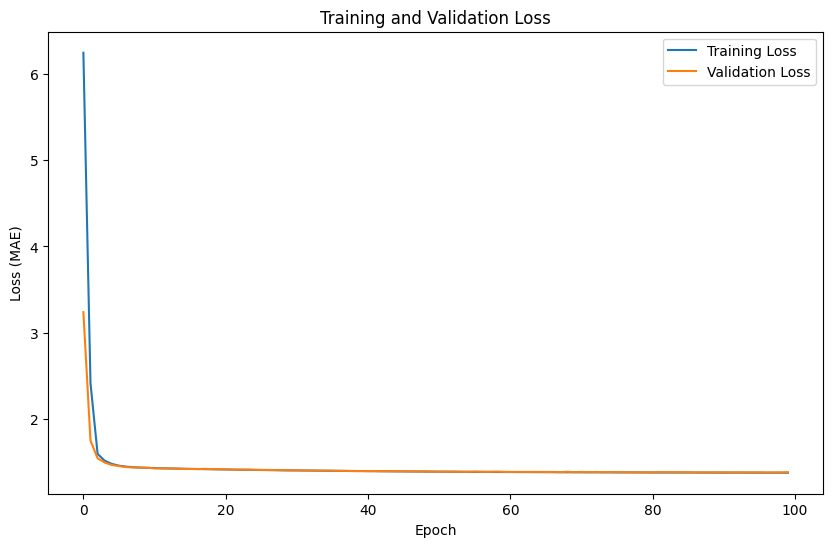

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()

In [152]:
model_NN.fit(X_train_Modelling_SS, y_train, epochs=25, batch_size=64)

Epoch 1/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2042
Epoch 2/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2042
Epoch 3/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2031
Epoch 4/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2032
Epoch 5/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2028
Epoch 6/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2036
Epoch 7/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2032
Epoch 8/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2035
Epoch 9/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2032
Epoch 10/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2027
Epoch 11/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2028
Epoch 12/25
1054/1054 [==============================] - 1s 1ms/step - loss: 1.2033
E

In [154]:
X_test.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M,Relation_DL,Relation_HL,Relation_HD,Volume,Density,Ratio_ShuWei,Ratio_VisWei,Ratio_SheWei
count,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000
mean,1.319795,1.026357,0.348693,23.464627,10.130220,5.072615,6.745876,0.313604,0.323347,0.363049,0.775045,0.262342,0.338582,0.142000,169.895615,0.431193,0.216816,0.292944
std,0.286950,0.236593,0.092259,12.641703,5.611779,2.791563,3.575650,0.463962,0.467759,0.480884,0.030844,0.030866,0.039394,0.078692,29.882239,0.078422,0.031132,0.041271
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.084507,0.051643,0.046948
25%,1.162500,0.887500,0.300000,13.536886,5.740774,2.877474,3.968930,0.000000,0.000000,0.000000,0.758929,0.245455,0.317460,0.080160,155.302527,0.397974,0.198827,0.267559
50%,1.387500,1.075000,0.362500,23.813580,9.979024,4.989512,6.945627,0.000000,0.000000,0.000000,0.776596,0.261538,0.337079,0.143090,167.005385,0.432040,0.215712,0.288873
75%,1.537500,1.200000,0.412500,32.290081,14.047177,7.016501,9.171063,1.000000,1.000000,1.000000,0.792308,0.278261,0.357143,0.198190,180.301513,0.463221,0.233428,0.314233
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,1.000000,1.000000,1.000000,2.027027,2.483516,3.183099,0.876268,2297.005110,5.537313,2.146974,2.567766


In [155]:
# Inf values to 0
X_test = X_test.replace([np.inf, -np.inf], 0)

In [116]:
X_test_NN = scaler.fit_transform(X_test)

In [117]:
y_pred = model_NN.predict(X_test_NN)

1543/1543 [==============================] - 2s 916us/step


## XGBoost

In [23]:
X_train_Modelling_MC, X_test  = dataset(1, 0, 0)
y_train = X_train_Modelling_MC['Age']
X_train_Modelling_MC = X_train_Modelling_MC.drop(['Age'], axis=1)

In [25]:
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Definir el espacio de búsqueda de hiperparámetros
space = {
    'max_depth': hp.choice('max_depth', range(2, 19)),
    'learning_rate': hp.quniform('learning_rate', 0.01, 0.1, 0.01),
    'subsample': hp.quniform('subsample', 0.5, 0.8, 0.1),
    'gamma': hp.quniform('gamma', 0, 5, 0.5),
    'min_child_weight': hp.quniform('min_child_weight', 5, 15, 1),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.1),
    'reg_alpha': hp.quniform('reg_alpha', 0.5, 1, 0.1),
    'reg_lambda': hp.quniform('reg_lambda', 1, 10, 0.5),
    'n_estimators': hp.choice('n_estimators', range(50, 600))
}

# Función objetivo para hyperopt
def objective(space):
    model_XGB = xgb.XGBRegressor(max_depth = int(space['max_depth']),
                             learning_rate = space['learning_rate'],
                             subsample = space['subsample'],
                             gamma = space['gamma'],
                             min_child_weight = int(space['min_child_weight']),
                             colsample_bytree = space['colsample_bytree'],
                             reg_alpha = space['reg_alpha'],
                             reg_lambda = space['reg_lambda'],
                             n_estimators = int(space['n_estimators']))
    
                             
    mae = cross_val_score(model_XGB, X_train_Modelling_MC, y_train, cv=5, scoring=make_scorer(mean_absolute_error)).mean()

    return {'loss': mae, 'status': STATUS_OK}


# Run the algorithm
trials = Trials()
best_XGB = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print("Best: ", best_XGB)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [1:07:18<00:00, 40.39s/trial, best loss: 1.3714595765691375]
Best:  {'colsample_bytree': 0.8, 'gamma': 2.5, 'learning_rate': 0.02, 'max_depth': 7, 'min_child_weight': 12.0, 'n_estimators': 110, 'reg_alpha': 0.5, 'reg_lambda': 4.5, 'subsample': 0.7000000000000001}


In [28]:
# Entrenar el modelo con los mejores hiperparámetros
model_XGB = xgb.XGBRegressor(
    n_estimators=int(best_XGB['n_estimators']),
    max_depth=int(best_XGB['max_depth']),
    learning_rate=best_XGB['learning_rate'],
    subsample=best_XGB['subsample'],
    gamma=best_XGB['gamma'],
    min_child_weight=best_XGB['min_child_weight'],
    colsample_bytree=best_XGB['colsample_bytree'],
    reg_alpha=best_XGB['reg_alpha'],
    reg_lambda=best_XGB['reg_lambda'],
    random_state=42
)


# Stacking

## Option 1

In [116]:
X_train_stack, X_test_stack  = dataset(0, 0, 0)
y_train_stack = X_train_stack['Age']
X_train_stack = X_train_stack.drop(['Age'], axis=1)

In [101]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam


# Función para crear el modelo
def create_model():
    model = Sequential()
    model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))  # Capa de entrada
    model.add(Dense(128, activation='relu'))  # Capa oculta
    model.add(Dense(1, activation='linear'))  # Capa de salida
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

# Crear el modelo envuelto
model_NN = KerasRegressor(build_fn=create_model, epochs=100, batch_size=64, verbose=0)

C:\Users\Jose\AppData\Local\Temp\ipykernel_18924\2154055001.py:15: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_NN = KerasRegressor(build_fn=create_model, epochs=100, batch_size=64, verbose=0)


In [115]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from mlxtend.regressor import StackingCVRegressor
from sklearn.metrics import mean_absolute_error, make_scorer    

linear_regression = LinearRegression()


# Ahora puedes usar model_NN_scaled en lugar de model_NN en tu stacking_regressor
stacking_regressor = StackingCVRegressor(regressors=[model_LGBM, model_XGB],
                                         meta_regressor=linear_regression,
                                         random_state=42,
                                         use_features_in_secondary=True)

# Entrenar el stacking_regressor
stacking_regressor.fit(X_train_stack, y_train_stack)

# Predecir con el stacking_regressor
y_pred = stacking_regressor.predict(X_test)


KeyboardInterrupt: 

In [ ]:
mae = cross_val_score(stacking_regressor, X_train_stack, y_train_stack, cv=5, scoring=make_scorer(mean_absolute_error)).mean()
print("MAE stacking_regressor: ", mae)

MAE stacking_regressor:  1.4171015120117967


In [121]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from mlxtend.regressor import StackingCVRegressor
from sklearn.metrics import mean_absolute_error, make_scorer    


linear_regression = LinearRegression()

# Construir el modelo de Stacking
stacking_regressor = StackingCVRegressor(regressors=[model_LGBM, model_XGB],
                                         meta_regressor=linear_regression,
                                         random_state=42,
                                         use_features_in_secondary=True)

# Entrenar todos los modelos
for clf in [model_LGBM, model_XGB, stacking_regressor]:
    scores = cross_val_score(clf, X_train_stack, y_train_stack, cv=5, scoring=make_scorer(mean_absolute_error))
    print(f"{clf.__class__.__name__}: {scores.mean()} ± {scores.std()}")


LGBMRegressor: 1.3986938948893792 ± 0.01089376654788195
XGBRegressor: 1.3720313414726184 ± 0.008981053717264735
StackingCVRegressor: 1.396829325810374 ± 0.010393019872928174


In [100]:
y_pred = model_LGBM.predict(X_test)

In [29]:
X_train_OHE.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M
0,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,0,1,0
1,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,0,1,0
2,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,0,0,1
3,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,1,0,0
4,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,0,1,0


In [38]:
# Extrae la columna 'Age' como tu vector objetivo y luego elimínala de X_train_OHE
y_train = X_train_OHE['Age']
X_train_OHE = X_train_OHE.drop(columns='Age')


,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M
0,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,0,1,0
1,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,0,1,0
2,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,0,0,1
3,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,1,0,0
4,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,0,1,0


## Option 2

In [73]:
y= y_train
X= X_train_Modelling_MC

In [75]:
from sklearn.model_selection import KFold
import numpy as np

# Inicializa los modelos
models = [model_knn, model_RF, model_LGBM, model_XGB, model_Lasso]

# Inicializa KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Para almacenar las predicciones OOF de cada modelo
oof_predictions = np.zeros((X.shape[0], len(models)))

# Convierte los DataFrames a arrays de NumPy
X_np = X.values
y_np = y.values

# Entrena cada modelo
for i, model in enumerate(models):
    for train_index, test_index in kf.split(X):
        # Divide los datos en entrenamiento y prueba
        X_train, X_test = X_np[train_index], X_np[test_index]
        y_train, y_test = y_np[train_index], y_np[test_index]

        # Entrena el modelo
        model.fit(X_train, y_train)

        # Genera las predicciones OOF
        oof_predictions[test_index, i] = model.predict(X_test)

In [76]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Define el espacio de búsqueda de hiperparámetros
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 10),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.05),
    'max_depth':  hp.choice('max_depth', np.arange(2, 24, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'gamma': hp.uniform('gamma', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
}

# Define la función objetivo
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': params['max_depth'],
        'min_child_weight': params['min_child_weight'],
        'subsample': params['subsample'],
        'gamma': params['gamma'],
        'colsample_bytree': params['colsample_bytree'],
    }
    
    model = XGBRegressor(**params)
    score = cross_val_score(model, oof_predictions, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1).mean()
    return {'loss': -score, 'status': STATUS_OK}

# Ejecuta la optimización
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)


100%|██████████| 20/20 [32:45<00:00, 98.26s/trial, best loss: 4.182116779344621] 


In [77]:
# Convierte 'n_estimators' a int
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = np.arange(1, 14, dtype=int)[best['max_depth']]

# Entrena el modelo de segundo nivel con los mejores hiperparámetros
second_level_model = XGBRegressor(**best)
second_level_model.fit(oof_predictions, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9506658838357855, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.5844147318986224, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.010971396780106444, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=2.0, missing=nan, monotone_constraints=None,
             n_estimators=390, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
X_test = pd.read_csv('input/test.csv')
X_test.drop(columns='id', inplace=True)

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,I,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552
1,I,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930
2,F,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415
3,F,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676
4,I,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066


In [ ]:
X_test = pd.concat([X_test, pd.get_dummies(X_test['Sex'], prefix='Sex')], axis=1)
X_test.drop('Sex', axis=1, inplace=True)

In [251]:
X_test.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M
0,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552,0,1,0
1,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930,0,1,0
2,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415,1,0,0
3,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676,1,0,0
4,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066,0,1,0


In [134]:
X_test.drop('id', axis=1, inplace=True)

In [252]:
y_pred = model_LGBM.predict(X_test)

In [248]:
X_test.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
count,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000
mean,1.319795,1.026357,0.348693,23.464627,10.130220,5.072615,6.745876
std,0.286950,0.236593,0.092259,12.641703,5.611779,2.791563,3.575650
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524
25%,1.162500,0.887500,0.300000,13.536886,5.740774,2.877474,3.968930
50%,1.387500,1.075000,0.362500,23.813580,9.979024,4.989512,6.945627
75%,1.537500,1.200000,0.412500,32.290081,14.047177,7.016501,9.171063
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248


In [136]:
# Inicializa una matriz para almacenar las predicciones de primer nivel para X_test
test_predictions = np.zeros((X_test.shape[0], len(models)))

# Genera las predicciones de primer nivel para X_test
for i, model in enumerate(models):
    test_predictions[:, i] = model.predict(X_test)

# Usa el modelo de segundo nivel para generar las predicciones finales
y_pred = second_level_model.predict(test_predictions)


c:\Users\Jose\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
c:\Users\Jose\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\Jose\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


In [ ]:
X_test.head()

In [ ]:
y_pred = model_LGBM.predict(X_test)

# Submission

In [159]:
X_test_submission = pd.read_csv('input/test.csv') # Test data

In [160]:
id_test = X_test_submission['id']

In [161]:
y_pred = X_test_final['Age']

In [42]:
y_pred

0         7.503386
1         7.754792
2        10.915746
3         9.610624
4         7.432042
           ...    
49363     9.376763
49364     8.042702
49365    13.206079
49366     9.892319
49367    12.045642
Name: Age, Length: 49368, dtype: float64

In [43]:
"""import pandas as pd

def custom_round(x):
    if 28 <= x < 28.5: 
        return 27
    elif 28.5 <= x < 29:
        return 29
    else:
        return round(x)

y_pred= y_pred.apply(custom_round)"""


'import pandas as pd\n\ndef custom_round(x):\n    if 28 <= x < 28.5: \n        return 27\n    elif 28.5 <= x < 29:\n        return 29\n    else:\n        return round(x)\n\ny_pred= y_pred.apply(custom_round)'

In [162]:
# Submission to a file
# Rounded pred increases the score
submission = pd.DataFrame({'id': id_test, 'Age': np.round(y_pred,0)})
submission.to_csv('submission.csv', index=False)